In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#new
from sklearn.model_selection import train_test_split
import xgboost as xgb

Wczytanie danych

In [2]:
#sciezka
data=pd.read_csv('dataKOBE.csv')

Zobaczmy atrybuty i ich typy:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

Weźmy pod uwagę analityczne znaczenie poszczególnych atrybutów, patrząc na liczbę przyjmowanych przez nie wartości.

In [4]:
atry =[wart for wart in data if data[wart].dtype=='object']
for wart in atry:
    print("")
    print(data[wart].value_counts())


Jump Shot                             18880
Layup Shot                             2567
Driving Layup Shot                     1978
Turnaround Jump Shot                   1057
Fadeaway Jump Shot                     1048
Running Jump Shot                       926
Pullup Jump shot                        476
Turnaround Fadeaway shot                439
Slam Dunk Shot                          411
Reverse Layup Shot                      395
Jump Bank Shot                          333
Driving Dunk Shot                       310
Dunk Shot                               262
Tip Shot                                182
Alley Oop Dunk Shot                     122
Step Back Jump shot                     118
Floating Jump shot                      114
Driving Reverse Layup Shot               97
Hook Shot                                84
Driving Finger Roll Shot                 82
Alley Oop Layup shot                     80
Reverse Dunk Shot                        75
Running Layup Shot             

Widzimy, że atrybuty 'team_id' i 'team_name' przyjmują po jednej wartości (odpowiednio: '1610612747' i 'Los Angeles Lakers'). Są zatem nieistotne w dalszej analizie. Usuwamy je zatem.

In [5]:
data=data.drop(['team_id','team_name'], axis=1) #axis=1 oznacza usunięcie całych kolumn

Z przeglądu danych zauważyć można, że atrybut 'matchup' w zależności od występowania separatora 'vs' albo '@' określa, czy mecz był grany odpowiednio: "u siebie" ('home'), bądź "na wyjeździe" ('away'). Jako, że mamy już informację dotyczącą przeciwnika ('opponent'), możemy usunąć kolumnę 'matchup' i stworzyć nową - 'home', która będzie zawierać infromacje dotyczące miejsca rozegrania meczu (jak wyżej).

In [6]:
data['home']=data['matchup'].apply(lambda x: 1 if 'vs' in x else 0) #1 dla 'home', 0 dla 'away'
data=data.drop('matchup',axis=1)

Weźmy pod uwagę dwie pary atrybutów określających położenie w momencie oddania strzału - loc_x i loc_y oraz lon i lat. Przedstawmy je na wykresach (dla poprawy przejrzystości w drugim wykresie odwróciliśmy kolejność osi y)

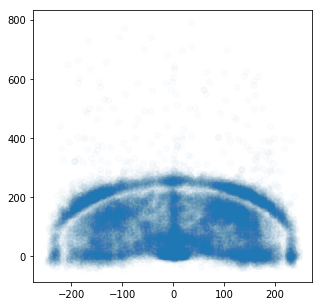

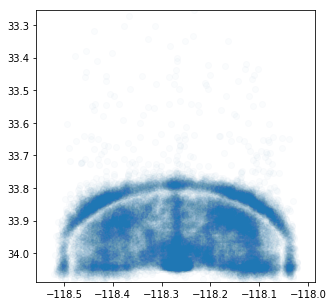

In [7]:
#plt.subplot()
plt.figure(figsize=(5,5))
plt.scatter(x=data['loc_x'],y=data['loc_y'],alpha=0.02)

plt.figure(figsize=(5,5))
plt.ylim(max(data['lat']), min(data['lat'])) #odwrócenie kolejności wartości na osi y
plt.scatter(x=data['lon'],y=data['lat'],alpha=.02)

Widzimy, że wartości są bardzo silnie skorelowane. Para loc_x i loc_y jest pewną wewnętrzną notacją, a lon i lat określa dokładne położenie geograficzne (boisko Lakersów). Co ciekawe, nawet dla meczów wyjazdowych położenie geograficzne jest przeskalowane dla wartości odpowiadających rodzimemu boisku). Ze względu na niejasności związane z tym skalowaniem, usuńmy lon i lat, zostawiając w jednakowym stopniu istotne loc_x i loc_y. W ten sposób unikamy korzystania z silnie odpowiadających sobie danych.

In [8]:
data=data.drop(['lon','lat'],axis=1)

Zauważmy również, że atrybuty 'minutes_remaining' (minuty do końca kwarty (uwaga!: kwarty w NBA mają 12 min, a nie 10, jak w Polsce)) oraz 'seconds_remaining' (wartości 0-59) logicznie jest połączyć, tworząc jeden atrybut 'time_remaining_seconds' wyrażony w sekundach.

In [9]:
data['time_remaining_seconds']=data['minutes_remaining']*60+data['seconds_remaining']
data=data.drop(['minutes_remaining','seconds_remaining'],axis=1)

Zauważmy, że Koby w najgorzej radzi sobie w ostatnich sekundach kazdej z kwart, ale chętnie podejmuje próby takich rzutów. Sensownym wydaje się utworzenie flagera określającego, czy rzut wykonany został w ostatnich 3 sekundach kwarty. 

In [10]:
print("Ogólna średnia Kobiego: ",np.mean(data["shot_made_flag"]))

tabela = pd.pivot_table(data,index=["time_remaining_seconds"],values=["shot_made_flag"],aggfunc=[np.mean, len])
tabela.query('time_remaining_seconds == ["0","1","2","3","4","5","6","7","8","9","10"]')

Ogólna średnia Kobiego:  0.44616103047048294


,mean,len
,shot_made_flag,shot_made_flag
time_remaining_seconds,,
0,0.180365,520.0
1,0.275281,212.0
2,0.250000,131.0
3,0.345679,99.0
4,0.555556,85.0
5,0.409836,70.0
6,0.437500,56.0
7,0.367347,53.0


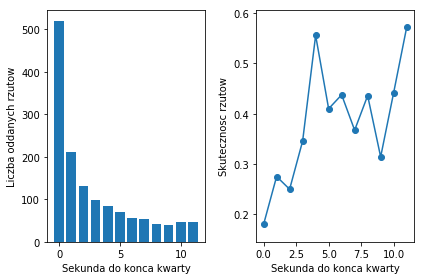

In [11]:
liczba_rzutow = np.array(tabela["len"][0:12]).transpose()
plt.subplot(1, 2, 1)
plt.bar(np.arange(12),liczba_rzutow[0])
plt.xlabel("Sekunda do konca kwarty")
plt.ylabel("Liczba oddanych rzutow")
plt.subplot(1, 2, 2)
skutecznosc_rzutow = np.array(tabela["mean"][0:12]).transpose()
plt.scatter(np.arange(12),skutecznosc_rzutow[0])
plt.plot(np.arange(12),skutecznosc_rzutow[0])
plt.xlabel("Sekunda do konca kwarty")
plt.ylabel("Skutecznosc rzutow")
plt.tight_layout()


In [12]:
data['last_3_seconds']=data.time_remaining_seconds.apply(lambda x: 1 if x<=3 else 0)

Kolejnym atrybutami bez znaczenia w klasyfikacji będą wszystkie id - 'game_id','game_event_id','shot_id'. Usuwamy je zatem.

In [13]:
data=data.drop(['game_id','game_event_id','shot_id'],axis=1)

Atrybut 'season' pozwala razem z miesiącem z atrybutu 'game_date', jednoznacznie wyznaczyć rok rozgrywki. Stwórzmy atrybut 'game_month', usuwając jednocześnie 'game_date' (dokładna data wydaje się być zbędna). 

In [14]:
data['game_date']=pd.to_datetime(data['game_date'])
data['game_month']=data['game_date'].dt.month
data=data.drop('game_date',axis=1)

Ostatnim etapem preprocessingu danych jest wyszczególnienie zbiorów uczącego i testowego. Zbiór testowy tworzyć będzie tą część naszych danych, która w kolumnie 'shot_made_flag' posiada wartość null(musimy zaklasyfikować jako rzut celny bądź chybiony).

## XGBoosting

Rzucmy okiem na to, jak wygladaja atrybuty naszych danych.

In [15]:
data.head()

,action_type,combined_shot_type,loc_x,loc_y,period,playoffs,season,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,home,time_remaining_seconds,last_3_seconds,game_month
0,Jump Shot,Jump Shot,167,72,1,0,2000-01,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,POR,0,627,0,10
1,Jump Shot,Jump Shot,-157,0,1,0,2000-01,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,0,622,0,10
2,Jump Shot,Jump Shot,-101,135,1,0,2000-01,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR,0,465,0,10
3,Jump Shot,Jump Shot,138,175,1,0,2000-01,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR,0,412,0,10
4,Driving Dunk Shot,Dunk,0,0,2,0,2000-01,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,0,379,0,10


Ponieważ XGBOOST, jak i wiele metod analitycznych, nie radzi sobie że zmiennymi kategorycznymi - tworzymy więc dodatkowe kolumny, tak by móc zapisać dana kategorie w postaci wektora zer i jedynek(dummy variables). Zastąpienie danych poprzez kolejne liczby naturalne mogłoby wprowadzić drzewa w błąd poprzez traktowanie tych wartości jako numeryczne.

In [16]:
dane2=data #kopia danych do dalszych obliczen
zmienne_kategoryczne=['action_type','combined_shot_type','season','opponent','shot_type','period','shot_zone_basic','shot_zone_area','shot_zone_range']
for var in zmienne_kategoryczne:
        data=pd.concat([data,pd.get_dummies(data[var],prefix=var)], 1)
        data=data.drop(var,1)


Spójrzmy ponownie, jak wyglądają dane po wprowadzeniu dummy variables.

In [17]:
data.head()

,loc_x,loc_y,playoffs,shot_distance,shot_made_flag,home,time_remaining_seconds,last_3_seconds,game_month,action_type_Alley Oop Dunk Shot,...,shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),shot_zone_range_16-24 ft.,shot_zone_range_24+ ft.,shot_zone_range_8-16 ft.,shot_zone_range_Back Court Shot,shot_zone_range_Less Than 8 ft.
0,167,72,0,18,NaN,0,627,0,10,0,...,0,0,0,0,1,1,0,0,0,0
1,-157,0,0,15,0.0,0,622,0,10,0,...,0,0,1,0,0,0,0,1,0,0
2,-101,135,0,16,1.0,0,465,0,10,0,...,0,1,0,0,0,1,0,0,0,0
3,138,175,0,22,0.0,0,412,0,10,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,1.0,0,379,0,10,0,...,1,0,0,0,0,0,0,0,0,1


Korzystać będziemy tylko z rekordów przechowujących informację na temat rzutu, to znaczy, czy został trafiony bądź spudlowany. To tworzy nasz zbiór treningowy.

In [18]:
data_tren=data[pd.notnull(data['shot_made_flag'])]

Poniżej wyznaczamy zbiór testowy poprzez wybranie tych wierszy, dla których nie jest wyznaczona klasyfikacja rzutu.

In [19]:
data_test = data[pd.isnull(data['shot_made_flag'])]
data_test = data_test.drop('shot_made_flag',1)

In [20]:
y_tren = data_tren['shot_made_flag']
uczacy = data_tren.drop(columns=['shot_made_flag'])
x_uczacy,x_test,y_uczacy,y_test = train_test_split(uczacy,y_tren,random_state=0,test_size=0.1)

Poniższa metoda pozwala wyznaczyć najodpowiedniejsze parametry dla tego modelu. Działanie algorytmu XGBOOST oraz znaczenie towarzyszących mu parametrów możemy poznać w poprzednim projekcie: https://ftims.edu.p.łódź.pl/mod/resource/view.php?id=61319. Wyznaczenie tych parametrów jest jednak procesem mocno złożonym obliczeniowo - stąd zakomentowanie, a sam wynik został wypisany poniżej.

In [21]:
#params={'n_estimators': [300,400], 'max_depth': [6,7,8], 'learning_rate': [0.01,0.1,1], 'subsample': [0.5,1], 'colsample_bytree': [0.8,1], 'seed': [0,1234]}
#grid=GridSearchCV(XGBClassifier(warm_start=True), param_grid=params, cv=5, scoring=log_scorer)
#grid.fit(uczacy,y)
#print(grid.bestparams)

In [22]:
#najlepsze parametry
params = {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'seed': 1234, 'subsample': 0.5}

Definiujemy funkcję <b>XGBmodel</b>, ktora jest odpowiedzialna za utworzenie modelu

In [23]:
def XGBmodel(x_train,x_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=1000,
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

model = XGBmodel(x_uczacy,x_test,y_uczacy,y_test,params)

[08:25:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[0]	test-rmse:0.49922
Will train until test-rmse hasn't improved in 10 rounds.
[08:25:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[1]	test-rmse:0.498531
[08:25:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=7
[2]	test-rmse:0.49781
[08:25:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[3]	test-rmse:0.497144
[08:25:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[4]	test-rmse:0.496384
[08:25:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[08:25:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=7
[47]	test-rmse:0.475925
[08:25:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=7
[48]	test-rmse:0.475572
[08:25:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[49]	test-rmse:0.475274
[08:25:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=7
[50]	test-rmse:0.474934
[08:25:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[51]	test-rmse:0.474625
[08:25:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nod

[08:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=7
[93]	test-rmse:0.466044
[08:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[94]	test-rmse:0.465906
[08:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[95]	test-rmse:0.465762
[08:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=7
[96]	test-rmse:0.465643
[08:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[97]	test-rmse:0.4655
[08:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes

[08:25:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[139]	test-rmse:0.461472
[08:25:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[140]	test-rmse:0.461419
[08:25:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=7
[141]	test-rmse:0.461348
[08:25:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=7
[142]	test-rmse:0.461292
[08:25:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[143]	test-rmse:0.461212
[08:25:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extr

[08:25:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[186]	test-rmse:0.459322
[08:25:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=7
[187]	test-rmse:0.459293
[08:25:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[188]	test-rmse:0.459244
[08:25:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[189]	test-rmse:0.459217
[08:25:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[190]	test-rmse:0.459201
[08:25:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extr

[08:25:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=7
[233]	test-rmse:0.458214
[08:25:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[234]	test-rmse:0.458196
[08:25:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=7
[235]	test-rmse:0.4582
[08:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[236]	test-rmse:0.458202
[08:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=7
[237]	test-rmse:0.458221
[08:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra 

Poniższy wykres przedstawia wpływ czynników na skuteczność rzutu Kobiego. Jak widać, największy wpływ mają: pozostały czas do końca kwarty oraz pozycja na boisku i jednocześnie odległość od kosza.

Text(0.5, 1.0, 'Feature Importance')

<Figure size 432x288 with 0 Axes>

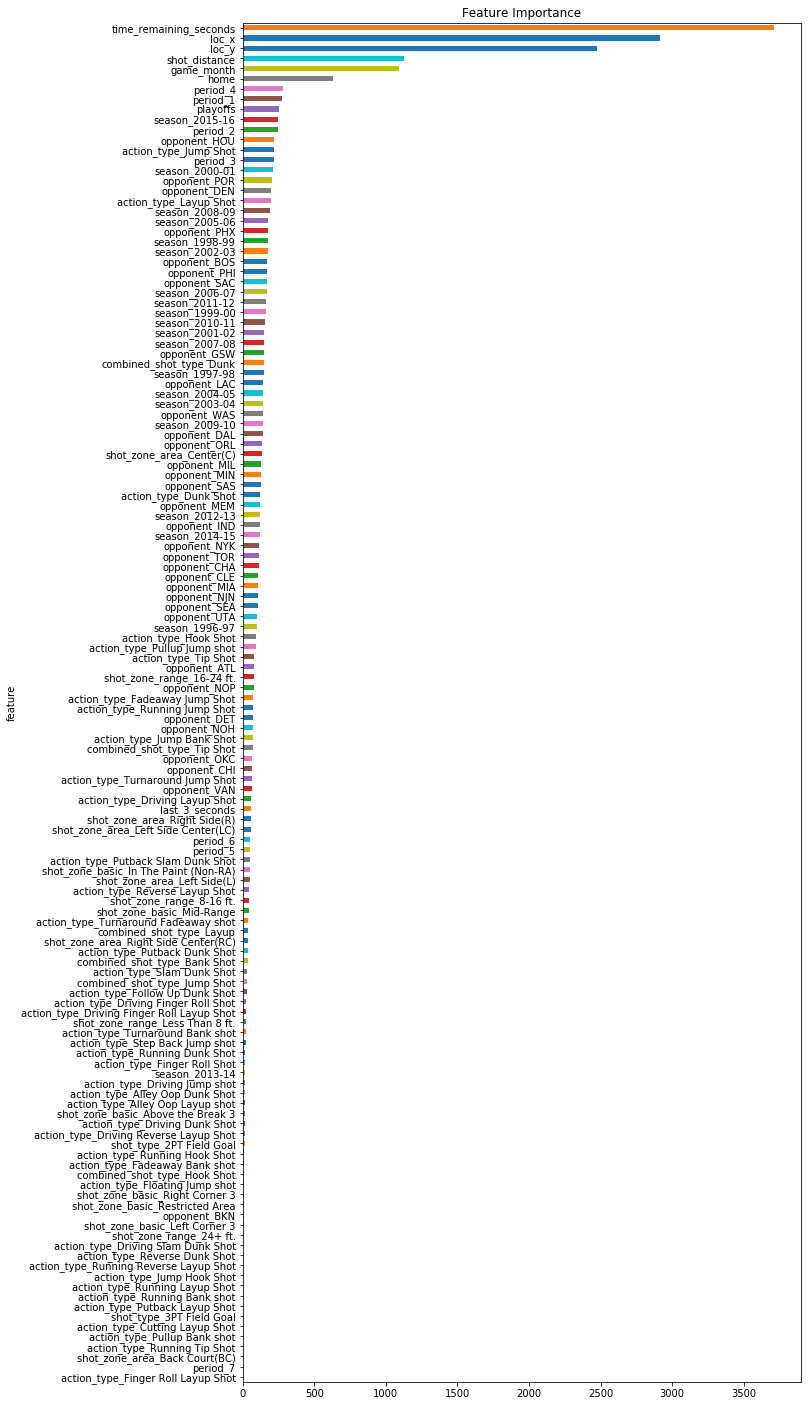

In [24]:
import operator
importance=model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'score'])
plt.figure()

df.plot(kind='barh', x='feature', y='score', legend=False, figsize=(10, 25))
plt.title("Feature Importance")

Spójrzmy więc zatem jak odległość koszykarza od kosza ma wpływ na jego celność. Możemy spodziewać się, że im dalej, tym trudniej. Okazuje się jednak, że raz na kilka rzutów udało się zdobyć punkty Kobiemu, co pokazują wahania na wykresie przy rzutach z dalszych odległości.

Text(0, 0.5, 'Skutecznosc rzutow')

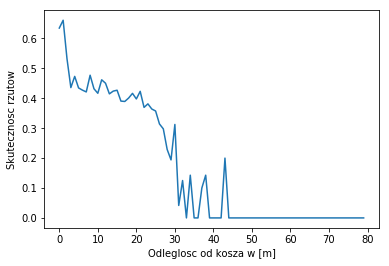

In [26]:
tabelaPV = pd.pivot_table(data,index=["shot_distance"],values=["shot_made_flag"],aggfunc=[np.mean])
skutecznosc_rzutow = np.array(tabelaPV["mean"]).transpose()
#plt.scatter(np.array(tabelaPV.index),skutecznosc_rzutow[0])
plt.plot(np.array(tabelaPV.index),skutecznosc_rzutow[0])
plt.xlabel("Odleglosc od kosza w [m]")
plt.ylabel("Skutecznosc rzutow")


Wykres ze znaczeniem czynników dla modelu stanowi jednak problem w interepretacji niektórych atrybutów. Stworzenie dummy variables dla zmiennych o charakterze kategorii nie pozwala nam jednak racjonalnie spojrzeć na wpływ poszczególnych zmiennych kategorycznych, ponieważ ocenia on wpływ pojedynczego obiektu danej kategorii. Możemy jedynie porównać, jaki przedstawiciel danej kategorii ma największy wpływ na rzut wewnątrz jej samej. Dla przykładu: Zauważmy, że kwarta 4 ma największe znaczenie wśród kwart, czy też sezon 2015-2016 wśród sezonów. Zobaczmy, jak przedstawia się skuteczność Kobiego dla każdego z sezonów.


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

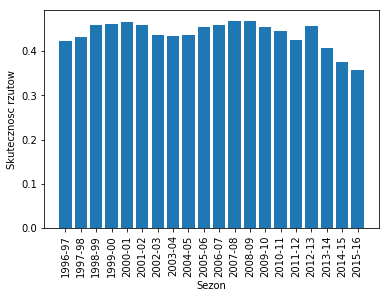

In [27]:
tabelaPV = pd.pivot_table(dane2,index=["season"],values=["shot_made_flag"],aggfunc=[np.mean])
skutecznosc_rzutow = np.array(tabelaPV["mean"]).transpose()
#plt.scatter(np.array(tabelaPV.index),skutecznosc_rzutow[0])
plt.bar(np.array(tabelaPV.index),skutecznosc_rzutow[0])
plt.xlabel("Sezon")
plt.ylabel("Skutecznosc rzutow")
plt.xticks(rotation=90)

Widzimy więc zatem, że Kobi wraz z wiekiem od pewnego momentu rzucał coraz gorzej. Z kolei sezon 2015-2016 jak się okazuje na podstawie powyższego wykresu był najbardziej odchylony od pozostałych - stąd jego ważność dla modelu. Podobnie jest z interpretacja kwarty czwartej (period_4) dla kwart. Jak poniższy wykres pokazuje, Kobi w czwartej kwarcie rzucał najgorzej, stąd największy wpływ wśród kwart. Kwarty... Ale skąd kwarta 5,6 i 7? Chodzi o dogrywki - w momencie zakończenia meczu remisem po regulaminowym czasie następuje seria dogrywek aż do wyłonienia zwycięzcy.


Text(0, 0.5, 'Skutecznosc rzutow')

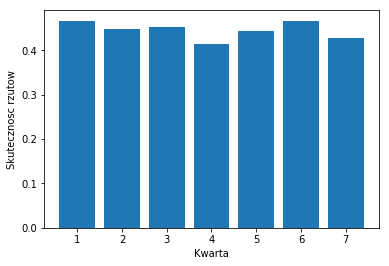

In [31]:
tabelaPV = pd.pivot_table(dane2,index=["period"],values=["shot_made_flag"],aggfunc=[np.mean])
skutecznosc_rzutow = np.array(tabelaPV["mean"]).transpose()
#plt.scatter(np.array(tabelaPV.index),skutecznosc_rzutow[0])
plt.bar(np.array(tabelaPV.index),skutecznosc_rzutow[0])
plt.xlabel("Kwarta")
plt.ylabel("Skutecznosc rzutow")


Podsumowując, dla każdego atrybutu o charakterze kategorii należy rozpatrywać wpływ danych kategorii indywidualnie - wewnątrz tego samego atrybutu.


<b>Przewidywanie używając XGBoost</b>

In [29]:
predykcja = model.predict(xgb.DMatrix(data_test), ntree_limit = model.best_ntree_limit)

Poniżej zapis podsumowania do pliku:

In [30]:
sub = pd.read_csv("sample_submission.csv")
sub['shot_made_flag'] = predykcja
sub.to_csv("klasyfikacja_podsumowanie.csv", index=False)

Nasz score Kaggle'owy to 0.60233, miejsce to 246/1117 